<a href="https://colab.research.google.com/github/mjmaher987/Stock-Prediction-Using-ML/blob/main/Codes/Stock-09012023-2115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Reshape, Flatten, LSTM
import yfinance as yf
import matplotlib.pyplot as plt

## Configs

In [2]:
Configs = {
    "training_percent" : 0.8,
    "epoch_number" : 50,
    "sequence_length" : 10,
    "num_features" : 5
}

## Preprocessing

In [3]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def get_history_from_yf(self):
        t = yf.Ticker(self.ticker)
        return t.history(period=self.period)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [4]:
etl_data = ETL('EURUSD=X')
history = etl_data.get_history_from_yf()

data = pd.DataFrame(
    {
        'open': pd.Series([x for x in history.Open]),
        'high': pd.Series([x for x in history.High]),
        'low': pd.Series([x for x in history.Low]),
        'close': pd.Series([x for x in history.Close]),
        'volume': pd.Series([x for x in history.Volume]),
    }
)

# Preprocessing
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Splitting into training and testing sets
train_size = int(Configs['training_percent'] * len(data))
train_data, test_data = data[:train_size], data[train_size:]

In [5]:
# Define the sequence length
sequence_length = Configs['sequence_length']
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data.iloc[i+sequence_length])
    return np.array(sequences), np.array(targets)
train_sequences, train_targets = create_sequences(train_data, sequence_length)
test_sequences, test_targets = create_sequences(test_data, sequence_length)

## Experiments

### Ichimoku

In [6]:
# def calculate_ichimoku_cloud(df):
#     # Tenkan-sen (Conversion Line) - Average of the highest high and lowest low over a certain period
#     df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2

#     # Kijun-sen (Base Line) - Average of the highest high and lowest low over a longer period
#     df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2

#     # Senkou Span A (Leading Span A) - Average of the Tenkan-sen and Kijun-sen, shifted forward
#     df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

#     # Senkou Span B (Leading Span B) - Average of the highest high and lowest low over an even longer period, shifted forward
#     df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)

#     # Chikou Span (Lagging Span) - Close price shifted backward
#     df['chikou_span'] = df['close'].shift(-26)

#     return df[['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span']]

# # Calculate Ichimoku Cloud components
# data_with_cloud = calculate_ichimoku_cloud(data)

# def ichimoku_trading_strategy(df):
#     signals = []
#     for i in range(len(df)):
#         if data['close'][i] > df['senkou_span_a'][i] and data['close'][i] > df['senkou_span_b'][i]:
#             signals.append('Buy')
#         elif data['close'][i] < df['senkou_span_a'][i] and data['close'][i] < df['senkou_span_b'][i]:
#             signals.append('Sell')
#         else:
#             signals.append('Hold')
#     return signals

# # Generate trading signals using the Ichimoku-based strategy
# trading_signals = ichimoku_trading_strategy(data_with_cloud)

# # Print the trading signals
# for i, signal in enumerate(trading_signals):
#     print(f"Day {i + 1}: {signal}")

In [7]:
# data_with_cloud

### NBEATS

In [8]:
class NBeatsModel(tf.keras.Model):
    def __init__(self):
        super(NBeatsModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(Configs['sequence_length'], 5))
        self.dense = tf.keras.layers.Dense(5)

    def call(self, inputs, training):
        x = self.flatten(inputs)
        x = self.dense(x)
        return x

def get_nbeats_model():
  return NBeatsModel()

nbeats_model = get_nbeats_model()
nbeats_model.compile(optimizer='adam', loss='mean_squared_error')
nbeats_model.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, validation_split=0.2)

# Make predictions
predictions_nbeats = nbeats_model.predict(test_sequences)
mse = mean_squared_error(test_targets, predictions_nbeats)
mae = mean_absolute_error(test_targets, predictions_nbeats)
rmse = mean_squared_error(test_targets, predictions_nbeats, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/50
103/103 [==============================] - 1s 4ms/step - loss: 1.3728 - val_loss: 0.0361
Epoch 2/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0180
Epoch 3/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0159
Epoch 4/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0156
Epoch 5/50
103/103 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0133
Epoch 6/50
103/103 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0115
Epoch 7/50
103/103 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 8/50
103/103 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 9/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0074
Epoch 10/50
103/103 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0056

### NHits

In [9]:
def build_nhits(input_shape, output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(output_shape)
    ])
    return model

nhits_model = build_nhits((Configs['sequence_length'], 5), 5)
nhits_model.compile(optimizer='adam', loss='mean_squared_error')
nhits_model.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, validation_split=0.2)


nhits_predictions = nhits_model.predict(test_sequences)
mse = mean_squared_error(test_targets, nhits_predictions)
mae = mean_absolute_error(test_targets, nhits_predictions)
rmse = mean_squared_error(test_targets, nhits_predictions, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/50
103/103 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 1.2065e-04
Epoch 2/50
103/103 [==============================] - 0s 1ms/step - loss: 5.9789e-04 - val_loss: 9.4158e-05
Epoch 3/50
103/103 [==============================] - 0s 2ms/step - loss: 5.6451e-04 - val_loss: 1.2716e-04
Epoch 4/50
103/103 [==============================] - 0s 1ms/step - loss: 5.3561e-04 - val_loss: 1.9639e-04
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 5.4185e-04 - val_loss: 1.0852e-04
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 5.0746e-04 - val_loss: 1.2126e-04
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 4.7992e-04 - val_loss: 9.4863e-05
Epoch 8/50
103/103 [==============================] - 0s 1ms/step - loss: 4.7630e-04 - val_loss: 1.2130e-04
Epoch 9/50
103/103 [==============================] - 0s 1ms/step - loss: 4.7626e-04 - val_loss: 1.3920e-04
Epoch 10/50
103/103 [===========

### RNN

In [10]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(Configs['sequence_length'], 5), return_sequences=False),
    tf.keras.layers.Dense(5)
])

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, validation_split=0.2)


# Make predictions
predictions_rnn = model_rnn.predict(test_sequences)
mse = mean_squared_error(test_targets, predictions_rnn)
mae = mean_absolute_error(test_targets, predictions_rnn)
rmse = mean_squared_error(test_targets, predictions_rnn, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Epoch 1/50
103/103 [==============================] - 1s 4ms/step - loss: 0.1344 - val_loss: 0.0068
Epoch 2/50
103/103 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 3.3144e-04
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 7.0286e-04 - val_loss: 2.7327e-04
Epoch 4/50
103/103 [==============================] - 0s 3ms/step - loss: 6.6934e-04 - val_loss: 2.0467e-04
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 6.4650e-04 - val_loss: 2.3374e-04
Epoch 6/50
103/103 [==============================] - 0s 3ms/step - loss: 6.5424e-04 - val_loss: 1.4077e-04
Epoch 7/50
103/103 [==============================] - 0s 3ms/step - loss: 6.0468e-04 - val_loss: 1.2341e-04
Epoch 8/50
103/103 [==============================] - 0s 2ms/step - loss: 6.0930e-04 - val_loss: 1.8293e-04
Epoch 9/50
103/103 [==============================] - 0s 3ms/step - loss: 5.7767e-04 - val_loss: 1.0147e-04
Epoch 10/50
103/103 [===================

### LSTM

In [11]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, 5), return_sequences=False),
    tf.keras.layers.Dense(5)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

lstm_model.fit(train_sequences, train_targets, epochs=Configs['epoch_number'], batch_size=32, verbose=1)


lstm_predictions = lstm_model.predict(test_sequences)
mse = mean_squared_error(test_targets, lstm_predictions)
mae = mean_absolute_error(test_targets, lstm_predictions)
rmse = mean_squared_error(test_targets, lstm_predictions, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Epoch 1/50
128/128 [==============================] - 4s 9ms/step - loss: 0.0466
Epoch 2/50
128/128 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 3/50
128/128 [==============================] - 1s 8ms/step - loss: 3.9645e-04
Epoch 4/50
128/128 [==============================] - 1s 9ms/step - loss: 3.6410e-04
Epoch 5/50
128/128 [==============================] - 1s 8ms/step - loss: 3.6128e-04
Epoch 6/50
128/128 [==============================] - 1s 6ms/step - loss: 3.5588e-04
Epoch 7/50
128/128 [==============================] - 1s 4ms/step - loss: 3.5376e-04
Epoch 8/50
128/128 [==============================] - 1s 5ms/step - loss: 3.5128e-04
Epoch 9/50
128/128 [==============================] - 1s 6ms/step - loss: 3.5392e-04
Epoch 10/50
128/128 [==============================] - 1s 6ms/step - loss: 3.5010e-04
Epoch 11/50
128/128 [==============================] - 1s 5ms/step - loss: 3.4068e-04
Epoch 12/50
128/128 [==============================] - 1s 4ms/step - lo

In [12]:
print(len(train_sequences[0][0]))

5


### Transformers

In [13]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = Configs['sequence_length'], 5, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)


transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape']
  )

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  hist = transformer.fit(train_sequences, train_targets, batch_size=32, epochs=Configs['epoch_number'], verbose=1, callbacks=callbacks)
  return hist


hist = fit_transformer(transformer_model)


Epoch 1/50
128/128 [==============================] - 13s 30ms/step - loss: 0.0611 - mae: 0.1611 - mape: 21541788.0000
Epoch 2/50
128/128 [==============================] - 4s 31ms/step - loss: 0.0110 - mae: 0.0815 - mape: 11010126.0000
Epoch 3/50
128/128 [==============================] - 5s 35ms/step - loss: 0.0080 - mae: 0.0689 - mape: 8304352.5000
Epoch 4/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0066 - mae: 0.0629 - mape: 6737588.5000
Epoch 5/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0051 - mae: 0.0545 - mape: 5775306.0000
Epoch 6/50
128/128 [==============================] - 5s 36ms/step - loss: 0.0038 - mae: 0.0464 - mape: 4891984.0000
Epoch 7/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0036 - mae: 0.0451 - mape: 4126853.7500
Epoch 8/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0031 - mae: 0.0418 - mape: 3602899.0000
Epoch 9/50
128/128 [==============================] - 5s 36ms

In [14]:
transformer_predictions = transformer_model.predict(test_sequences)
mse = mean_squared_error(test_targets, transformer_predictions)
mae = mean_absolute_error(test_targets, transformer_predictions)
rmse = mean_squared_error(test_targets, transformer_predictions, squared=False)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

32/32 [==============================] - 1s 10ms/step
Mean Squared Error: 0.0001781291878140608
Mean Absolute Error: 0.00931947180753754
Root Mean Squared Error: 0.011934644384265124


## Visualizations

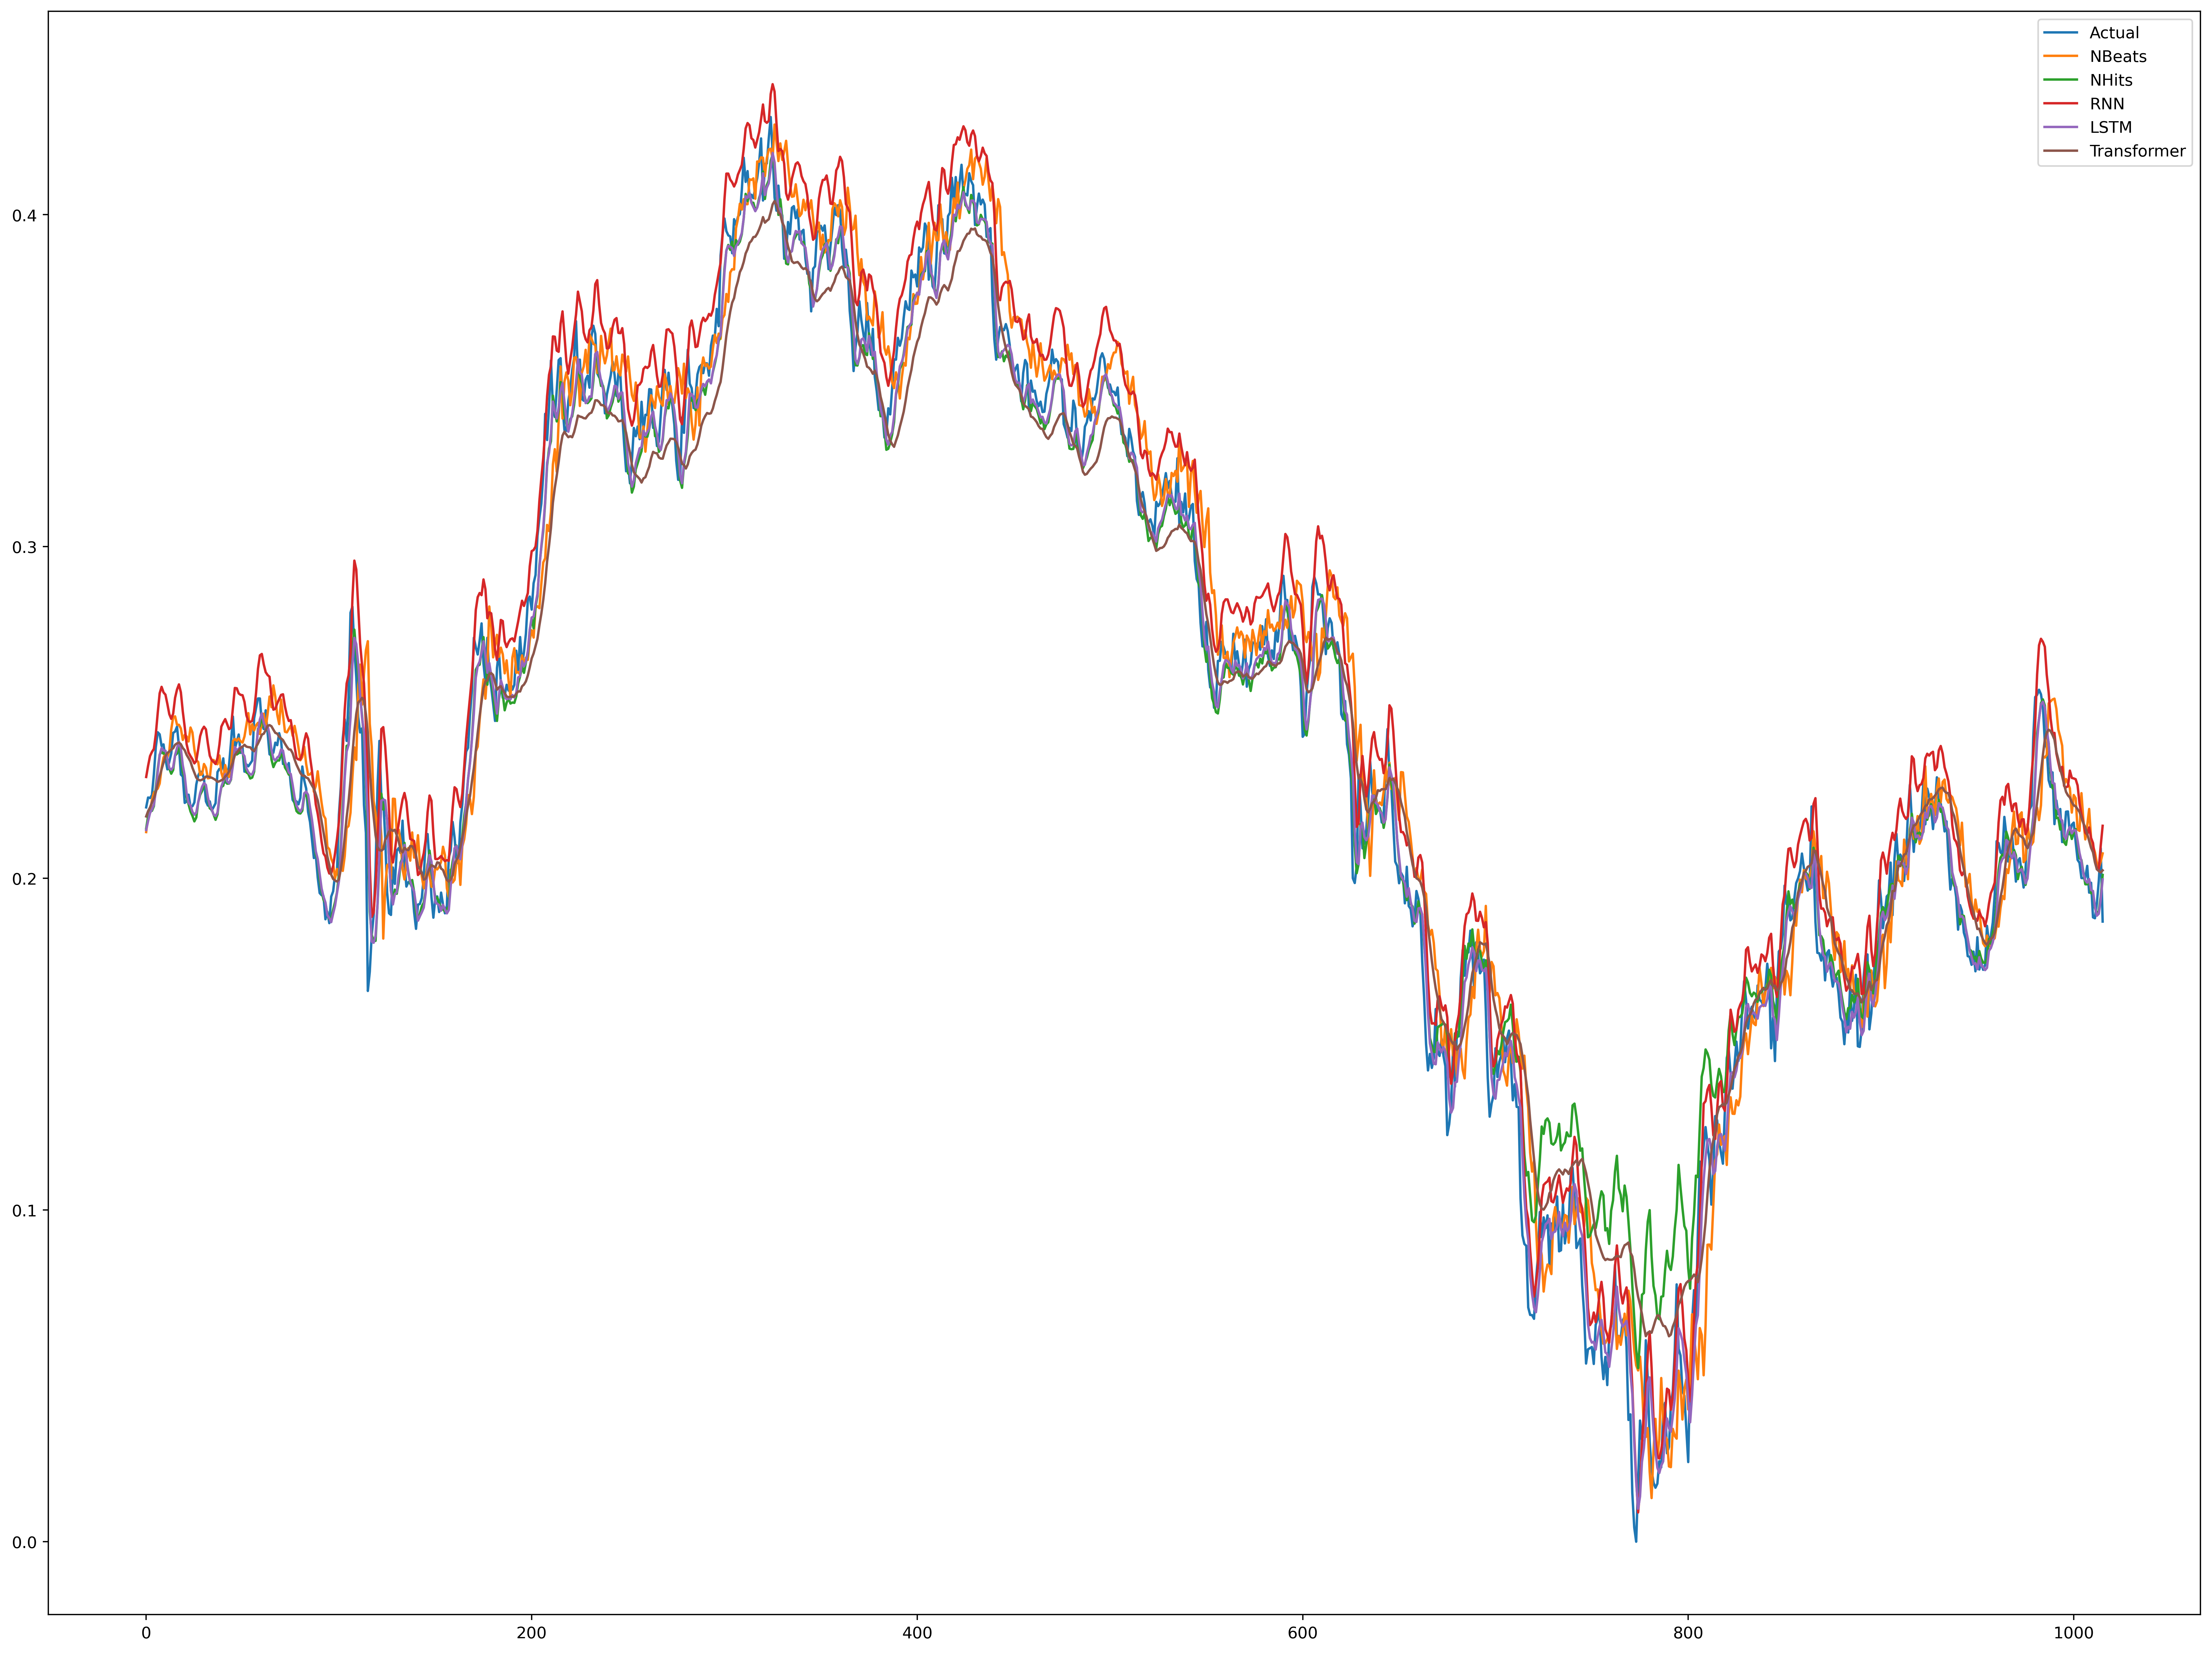

In [15]:
test_targets_close = [test_target[3] for test_target in test_targets]
nbeats_close = [predictions_nbit[3] for predictions_nbit in predictions_nbeats]
nhits_close = [nhits_prediction[3] for nhits_prediction in nhits_predictions]
rnn_close = [prediction_rnn[3] for prediction_rnn in predictions_rnn]
lstm_close = [lstm_prediction[3] for lstm_prediction in lstm_predictions]
transformer_close = [transformer_prediction[3] for transformer_prediction in transformer_predictions]

plt.figure(figsize=(24, 18), dpi=400)
plt.plot(test_targets_close, label='Actual')
plt.plot(nbeats_close, label='NBeats')
plt.plot(nhits_close, label='NHits')
plt.plot(rnn_close, label='RNN')
plt.plot(lstm_close, label='LSTM')
plt.plot(transformer_close, label='Transformer')
plt.legend()

### NBeats

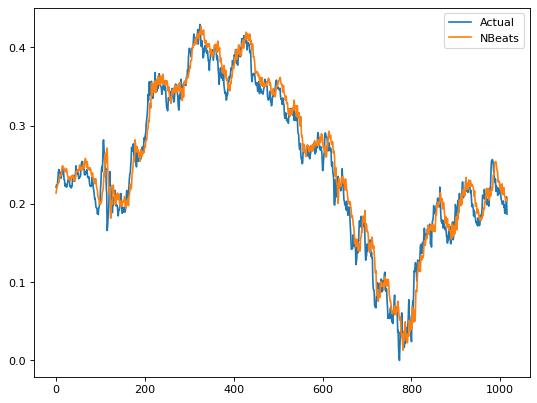

In [16]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_targets_close, label='Actual')
plt.plot(nbeats_close, label='NBeats')
plt.legend()

### NHits

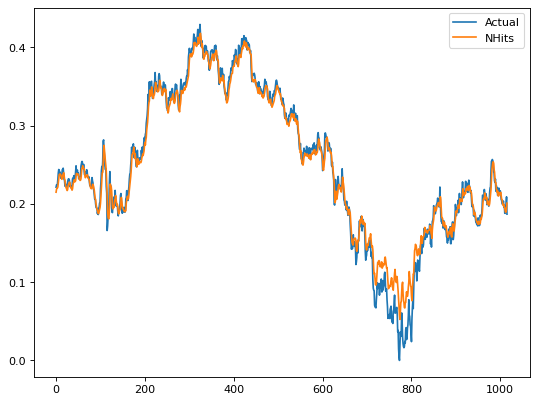

In [17]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_targets_close, label='Actual')
plt.plot(nhits_close, label='NHits')
plt.legend()

### LSTM

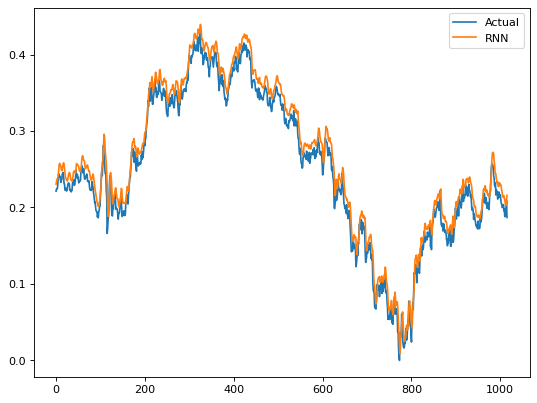

In [18]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_targets_close, label='Actual')
plt.plot(rnn_close, label='RNN')
plt.legend()

## RNN

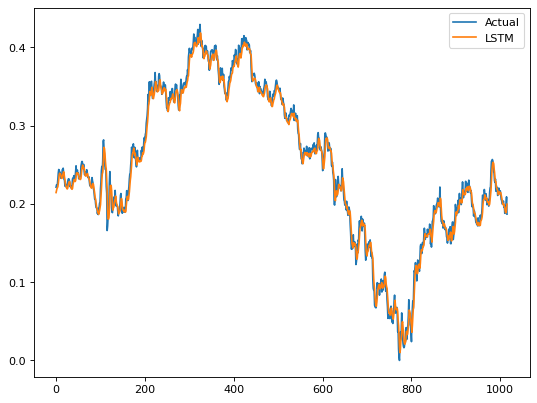

In [19]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_targets_close, label='Actual')
plt.plot(lstm_close, label='LSTM')
plt.legend()

### Transformer

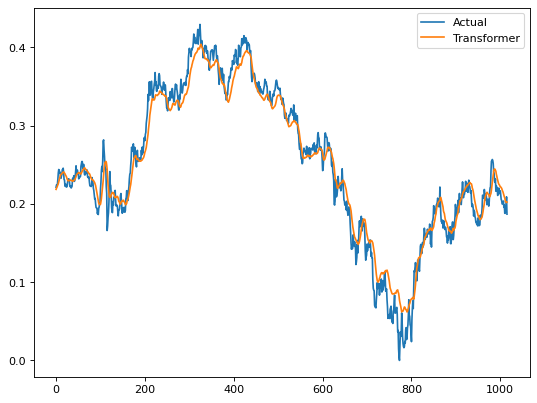

In [20]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(test_targets_close, label='Actual')
plt.plot(transformer_close, label='Transformer')
plt.legend()

Save and serialize models for the bot

In [23]:
# save models for bot usage
nbeats_model.save('./model_dumps/nbeats.tf')
nhits_model.save('./model_dumps/nhits.keras')
model_rnn.save('./model_dumps/rnn.keras')
lstm_model.save('./model_dumps/lstm.keras')
transformer_model.save('./model_dumps/transformer.keras')